# Análise de dados NHANES 2017-2018
Esta análise consiste do estudo de dados demográficos, de medidas corporais e pressão sanguínea obtido através do programa NHANES (National Health and Nutrition Examination Survey) conduzido nos Estados Unidos da América durante os anos de 2017-2018. <br>
Fonte: https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Tratamento inicial dos dados

Inicialmente, serão importados os dados demográficos dos pacientes examinados. O dataset DEMO_J possui diversas colunas, porém apenas quatro delas serão mantidas, são elas:

Coluna | Significado | Tipo | Unidade
-----|---|---|-----
RIAGENDR | Gênero | Categórico | -
RIDAGEYR| Idade | Numérico | Anos
DMDEDUC2 | Escolaridade | Categórico | -
DMDMARTL | Estado Civil | Categórico | - 

Devido ao custo de armazenamento, os dados categóricos estão codificados em uma representação numérica. A coluna SEQN será designada como índice visto que é composta por valores únicos cujo propósito é identificar o paciente durante o atendimento.

In [12]:
DEMO = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/DEMO_J.XPT', index='SEQN')
DEMO = DEMO[['RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'DMDMARTL']]
display(DEMO.head())
print('Linhas = {}\nColunas = {}'.format(DEMO.shape[0], DEMO.shape[1]))

,RIAGENDR,RIDAGEYR,DMDEDUC2,DMDMARTL
SEQN,,,,
93703.0,2.0,2.0,NaN,NaN
93704.0,1.0,2.0,NaN,NaN
93705.0,2.0,66.0,2.0,3.0
93706.0,1.0,18.0,NaN,NaN
93707.0,1.0,13.0,NaN,NaN


Linhas = 9254
Colunas = 4


Em seguida, traremos o dataset com as medidas corporais. Novamente, serão consideradas apenas algumas colunas de BMX_J, sendo elas:

Coluna | Significado | Tipo | Unidade
-----|---|---|-----
BMXWT | Peso | Numérico | kg
BMXHT| Altura | Numérico | cm

In [13]:
BMX = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BMX_J.XPT', index='SEQN')
BMX = BMX[['BMXWT', 'BMXHT']]
display(BMX.head())
print('Linhas = {}\nColunas = {}'.format(BMX.shape[0], BMX.shape[1]))

,BMXWT,BMXHT
SEQN,,
93703.0,13.7,88.6
93704.0,13.9,94.2
93705.0,79.5,158.3
93706.0,66.3,175.7
93707.0,45.4,158.4


Linhas = 8704
Colunas = 2


Por último, mas não menos importante, o dataset com as medidas de pressão arterial. De BMX_J, estudaremos apenas:

Coluna | Significado | Tipo | Unidade
-----|---|---|-----
BPXSY1 | Sístole1 | Numérico | mmHg
BPXDI1| Diástole1 | Numérico | mmHg
BPXSY2 | Sístole2 | Numérico | mmHg
BPXDI2| Diástole2 | Numérico | mmHg

In [14]:
BPX = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BPX_J.XPT', index='SEQN') 
BPX = BPX[['BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2']]
display(BPX.head())
print('Linhas = {}\nColunas = {}'.format(BPX.shape[0], BPX.shape[1]))

,BPXSY1,BPXDI1,BPXSY2,BPXDI2
SEQN,,,,
93703.0,NaN,NaN,NaN,NaN
93704.0,NaN,NaN,NaN,NaN
93705.0,NaN,NaN,NaN,NaN
93706.0,112.0,74.0,114.0,70.0
93707.0,128.0,38.0,128.0,46.0


Linhas = 8704
Colunas = 4


Devido ao fato de que cada paciente é unicamente identificado pelo seu número de sequência, e que não necessariamente ele esteja presente em todos os três datasets, será feito um inner join. A ideia é ter um dataframe final com todas as colunas de interesse.

In [15]:
df = pd.merge(DEMO, BMX, left_index=True, right_index=True, how='inner')
df = pd.merge(df, BPX, left_index=True, right_index=True, how='inner')
display(df.head())
print('Linhas = {}\nColunas = {}'.format(df.shape[0], df.shape[1]))

,RIAGENDR,RIDAGEYR,DMDEDUC2,DMDMARTL,BMXWT,BMXHT,BPXSY1,BPXDI1,BPXSY2,BPXDI2
SEQN,,,,,,,,,,
93703.0,2.0,2.0,NaN,NaN,13.7,88.6,NaN,NaN,NaN,NaN
93704.0,1.0,2.0,NaN,NaN,13.9,94.2,NaN,NaN,NaN,NaN
93705.0,2.0,66.0,2.0,3.0,79.5,158.3,NaN,NaN,NaN,NaN
93706.0,1.0,18.0,NaN,NaN,66.3,175.7,112.0,74.0,114.0,70.0
93707.0,1.0,13.0,NaN,NaN,45.4,158.4,128.0,38.0,128.0,46.0


Linhas = 8704
Colunas = 10


Por questões de uma melhor compreensão do conteúdo do dataframe, as colunas terão novos rótulos e os dados de colunas categóricas serão decodificados de uma representação numérica para strings com significado em linguagem natural.  

In [16]:
df.columns = ['Gender','Age','Education','Marital','Weight','Height','Systole1','Diastole1','Systole2','Diastole2']
df.Gender = df.Gender.replace({1.0: 'Male', 2.0: 'Female'})
df.Education = df.Education.replace({1.0: '-9th', 2.0: '9-11th', 3.0: 'High School', 4.0: 'Some College', 5.0: 'Graduate+', 7.0: 'Refused', 8.0: 'Don\'t Know'})
df.Marital = df.Marital.replace({1.0: 'Married', 2.0: 'Widowed', 3.0: 'Divorced', 4.0: 'Separated', 5.0: 'Never Married', 6.0: 'Living With Partner', 77: 'Refused', 99: 'Don\'t Know'})
display(df.head())
print('Linhas = {}\nColunas = {}'.format(df.shape[0], df.shape[1]))

,Gender,Age,Education,Marital,Weight,Height,Systole1,Diastole1,Systole2,Diastole2
SEQN,,,,,,,,,,
93703.0,Female,2.0,NaN,NaN,13.7,88.6,NaN,NaN,NaN,NaN
93704.0,Male,2.0,NaN,NaN,13.9,94.2,NaN,NaN,NaN,NaN
93705.0,Female,66.0,9-11th,Divorced,79.5,158.3,NaN,NaN,NaN,NaN
93706.0,Male,18.0,NaN,NaN,66.3,175.7,112.0,74.0,114.0,70.0
93707.0,Male,13.0,NaN,NaN,45.4,158.4,128.0,38.0,128.0,46.0


Linhas = 8704
Colunas = 10


No geral, devido a discrepância entre os dados de crianças e adultos, a análise que se segue considerará apenas as pessoas examinadas que tenham mais de 18 anos de idade. Adicionalmente, converteremos os dados de altura de centímetros (cm) para metros (m) a fim de integrar uma nova coluna ao dataframe: o índice de massa corporal ou BMI.

In [17]:
df = df[df['Age']>=18.0].copy()

df['Height'] = df['Height']*0.01
df['BMI'] = df['Weight']/(df['Height']**2)
display(df.head())
print('Linhas = {}\nColunas = {}'.format(df.shape[0], df.shape[1]))

,Gender,Age,Education,Marital,Weight,Height,Systole1,Diastole1,Systole2,Diastole2,BMI
SEQN,,,,,,,,,,,
93705.0,Female,66.0,9-11th,Divorced,79.5,1.583,NaN,NaN,NaN,NaN,31.725268
93706.0,Male,18.0,NaN,NaN,66.3,1.757,112.0,74.0,114.0,70.0,21.476821
93708.0,Female,66.0,-9th,Married,53.5,1.502,NaN,NaN,138.0,78.0,23.714497
93709.0,Female,75.0,Some College,Widowed,88.8,1.511,120.0,66.0,118.0,66.0,38.894128
93711.0,Male,56.0,Graduate+,Married,62.1,1.706,108.0,68.0,94.0,68.0,21.337009


Linhas = 5533
Colunas = 11


In [18]:
df.describe()

,Age,Weight,Height,Systole1,Diastole1,Systole2,Diastole2,BMI
count,5533.000000,5444.000000,5444.000000,4899.000000,4.899000e+03,5128.000000,5.128000e+03,5434.000000
mean,49.816555,82.468993,1.663623,125.984895,7.165462e+01,126.246490,7.210686e+01,29.691481
std,18.649364,22.980417,0.100669,19.728263,1.356110e+01,20.282001,1.313658e+01,7.439997
min,18.000000,32.600000,1.383000,72.000000,5.397605e-79,72.000000,5.397605e-79,14.203401
25%,33.000000,66.500000,1.589000,112.000000,6.400000e+01,112.000000,6.400000e+01,24.576145
50%,51.000000,78.900000,1.659000,124.000000,7.200000e+01,124.000000,7.200000e+01,28.457344
75%,65.000000,94.500000,1.736000,136.000000,8.000000e+01,136.000000,8.000000e+01,33.489376
max,80.000000,242.600000,1.977000,228.000000,1.360000e+02,236.000000,1.360000e+02,86.160237


O método *describe* acima revela que:
* A contagem de dados totais por coluna não é igual, isso implica na presença de NaNs. 
* A idade mínima é 18 anos, confirmando que a seleção de adultos foi de fato realizada. Enquanto a idade máxima é 80 anos.
* Como a média dos pesos é maior que a mediana, então a distribuição deve ser enviesada positivamente e possuir outliers à direita, o que na verdade já é possível perceber pelo peso máximo de 242.6kg. 
* O formato da distribuição dos pesos parece ser propagada ao índice de massa corporal, já que são diretamente proporcionais e a distribuição das alturas dá indícios de simetria devido às diferenças entre os quartis.
* As duas medidas de pressão sistólica possuem exatamente os mesmos 1º, 2º e 3º quartis. Entretando diferem em média. Será que essa diferença é estatisticamente significativa? A mesma afirmação e questionamento valem para as duas medidas de pressão diastólica.

In [19]:
df.isna().sum()

Gender         0
Age            0
Education    268
Marital      268
Weight        89
Height        89
Systole1     634
Diastole1    634
Systole2     405
Diastole2    405
BMI           99
dtype: int64

Visualizando a contagem de NaNs por coluna, podemos concluir que mesmo para os casos onde há uma maior quantidade de dados ausentes, este número não é tão expressivo em comparação à quantidade total de pacientes adultos examinados, ou seja 5533. Sendo assim, quando necessário, o tratamento de dados ausentes será feito através de sua remoção.

## Analisando as medidas de pressão sistólica

#### Comparação entre todas as amostras de pressão sistólica 1 e 2

As colunas sístole1 e sístole2 se tratam de medições realizadas uma após a outra, sendo separadas por um curto intervalo de tempo. Este procedimento serve para evitar erro humano durante o exame.

O primeiro passo se dará pela remoção de NaNs. Criaremos um novo dataframe que seja livre de dados não valorados de sístole 1 ou 2.

In [20]:
df1 = df[(df['Systole1'].notna()) & (df['Systole2'].notna())]
print('Nº de linhas removidas = {}'.format(df.shape[0] - df1.shape[0]))

Nº de linhas removidas = 722


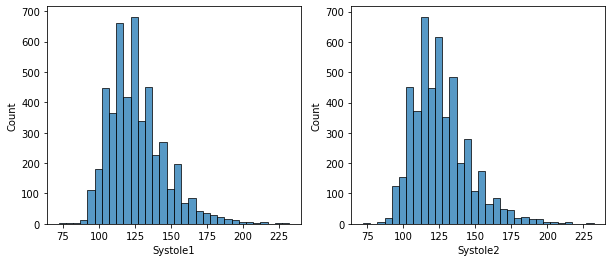

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharex=True)
sns.histplot(data=df1, x='Systole1', binwidth=5, ax=axes[0])
sns.histplot(data=df1, x='Systole2', binwidth=5, ax=axes[1])
plt.show()

		Pearson corr: 0.9662


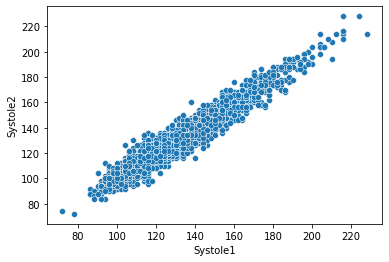

In [22]:
print('\t\tPearson corr: {:.4f}'.format(df1['Systole1'].corr(df1['Systole2'])))
sns.scatterplot(data=df1, x='Systole1', y='Systole2');

Através do histograma vemos que ambas as distribuições são muito semelhantes, e enviesadas positivamente como dito anteriormente. Devido a estas características devemos salientar a presença predominante de outliers à direita. O scatterplot revela que as medições de sístole são altamente correlacionadas linearmente. 

O passo seguinte se dará pela remoção de outliers das colunas sístole1 e sistole2 utilizando o método de Tukey para dados univariados.

In [23]:
q1 = df1['Systole1'].quantile(q=0.25)
q3 = df1['Systole1'].quantile(q=0.75)
iqr = q3 - q1
lines_before = df1.shape[0]
df1 = df1[(df1['Systole1'] > (q1-1.5*iqr)) & (df1['Systole1'] < (q3+1.5*iqr))]
print('Nº de linhas removidas = {}'.format(lines_before - df1.shape[0]))

Nº de linhas removidas = 141


In [24]:
q1 = df1['Systole2'].quantile(q=0.25)
q3 = df1['Systole2'].quantile(q=0.75)
iqr = q3 - q1
lines_before = df1.shape[0]
df1 = df1[(df1['Systole2'] > (q1-1.5*iqr)) & (df1['Systole2'] < (q3+1.5*iqr))]
print('Nº de linhas removidas = {}\nNº de linhas restantes = {}'.format(lines_before - df1.shape[0], df1.shape[0]))

Nº de linhas removidas = 58
Nº de linhas restantes = 4612


		Pearson corr: 0.9522


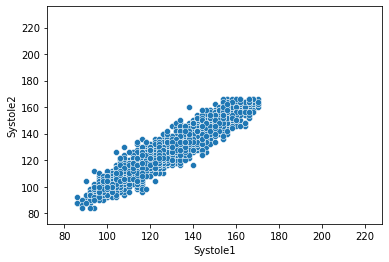

In [25]:
print('\t\tPearson corr: {:.4f}'.format(df1['Systole1'].corr(df1['Systole2'])))
sns.scatterplot(data=df1, x='Systole1', y='Systole2').set(xlim=(72,228), ylim=(72,236));

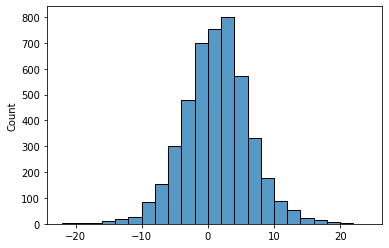

In [26]:
sns.histplot(df1['Systole1'] - df1['Systole2'], binwidth=2);

Visualmente, a distribuição das diferenças entre as medidas de sístole 1 e 2 parecem ser normalmente distribuídas. Entretanto, conclusões visuais nem sempre são adequadas. Para isso executaremos um teste de Shapiro-Wilk para testar a normalidade mais consistentemente.

In [27]:
stats.shapiro(df1['Systole1'] - df1['Systole2'])

(0.9797497391700745, 3.774910698293721e-25)

O teste de Shapiro-Wilk revelou um p-value igual a 3.77e-25 que é menor que o nível de significância adotado para o teste, ou seja, 0.05. Rejeitamos a hipótese nula de que a distribuição das diferenças é aproximadamente normal. Portanto, usaremos um teste de Wilcoxon para verificar se as medidas pareadas de sístole são estatisticamente iguais.

In [28]:
stats.wilcoxon(df1['Systole1'], df1['Systole2'])

WilcoxonResult(statistic=3413963.0, pvalue=6.002447073273366e-06)

O teste de Wilcoxon revelou um p-value menor que o nível de significância do teste que é 0.05. Rejeitamos a hipótese nula de que as medidas de sístole1 e sístole2 são iguais.

#### Comparação da pressão sistólica 1 por sexo e idade
Sabe-se que uma pressão sistólica alta é um forte de indicador de doenças como hipertensão arterial. Além disso, é de conhecimento comum que este tipo de problema de saúde se agrava conforme a idade aumenta. Será que há uma diferença significativa entre a pressão sistólica de homens e mulheres?

Para que possamos analisar melhor a relação da pressão sistólica com o sexo e a idade, criaremos uma nova coluna no dataframe de forma a transformar a idade numérica em intervalos categóricos.

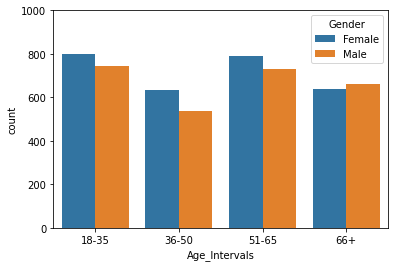

In [29]:
df['Age_Intervals'] = pd.cut(df['Age'], [18,35,50,65,80], include_lowest=True, labels=['18-35','36-50','51-65','66+'])
sns.countplot(data=df, x='Age_Intervals', hue='Gender').set(ylim=(0,1000));

O gráfico de barras acima mostra que as classes de interesse estão bem representadas, pois para todo sexo e para toda idade há uma quantidade significativa e quase uniforme de pacientes. Dito isso, consideraremos que na análise que segue não deverá haver viés relacionado à má representação.

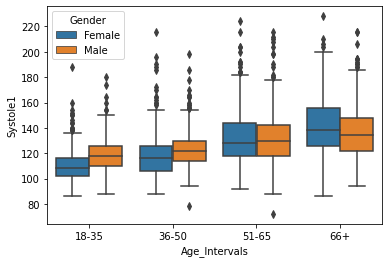

In [30]:
sns.boxplot(data=df, x='Age_Intervals', y='Systole1', hue='Gender');

O gráfico de caixas revela uma tendência de crescimento da pressão sistólica a medida que a idade aumenta. Confirmando visualmente nossas suposições iniciais. Homens entre 18 e 50 anos tendem a ter pressão sistólica maior que mulheres dentro da mesma faixa etária. Já na faixa dos 51 aos 65 anos, ambos os sexos parecem ter pressões sistólicas semelhantes. Contudo, a situação parece se inverter para pessoas maiores de 66 anos, homens apresentam medidas de sístole menor que mulheres. 

Para confirmar com mais propriedade as conclusões feitas com o box-plot, serão realizados testes de hipóteses. Para cada faixa etária, serão testadas a normalidade da pressão sistólica para cada sexo, e só depois testaremos a igualdade entre os sexos.

In [31]:
for age in ['18-35','36-50','51-65','66+']:
  print('Age {}:'.format(age))
  male_systole1 = df.loc[(df['Gender']=='Male') & (df['Age_Intervals']==age),'Systole1'].dropna()
  female_systole1 = df.loc[(df['Gender']=='Female') & (df['Age_Intervals']==age),'Systole1'].dropna()
  print('Male: Shapiro = {}'.format(stats.shapiro(male_systole1)))
  print('Female: Shapiro = {}'.format(stats.shapiro(female_systole1)))
  print(stats.mannwhitneyu(male_systole1, female_systole1), end='\n\n')

Age 18-35:
Male: Shapiro = (0.9706166386604309, 2.071271071324432e-10)
Female: Shapiro = (0.9366715550422668, 6.89477936922304e-17)
MannwhitneyuResult(statistic=137484.5, pvalue=5.2302963907869326e-45)

Age 36-50:
Male: Shapiro = (0.957950234413147, 1.5460249747079047e-10)
Female: Shapiro = (0.9224153757095337, 3.998170740981261e-16)
MannwhitneyuResult(statistic=102391.0, pvalue=2.624607408347283e-10)

Age 51-65:
Male: Shapiro = (0.9610551595687866, 4.158907159629299e-12)
Female: Shapiro = (0.9630112648010254, 3.428596165658271e-12)
MannwhitneyuResult(statistic=222603.0, pvalue=0.3903659507847398)

Age 66+:
Male: Shapiro = (0.9648102521896362, 1.1646388020647436e-10)
Female: Shapiro = (0.9817180037498474, 2.3296238396142144e-06)
MannwhitneyuResult(statistic=134508.5, pvalue=9.198412222441116e-07)



Como todos os testes de Shapiro revelaram p-value menor que o nível de significância (0.05), concluímos que as medidas de sístole não seguem distribuição normal em nenhum dos casos. Analisaremos os testes de Mann-Whitney para dados não pareados.
* 18-35 anos: p-value < 0.05. Rejeitamos a hipótese nula de que as pressões sistólicas são iguais para homens e mulheres.
* 36-50 anos: p-value < 0.05. Rejeitamos a hipótese nula.
* 51-65 anos: p-value > 0.05. Não rejeitamos a hipótese nula, as medidas de sístole entre homem e mulheres são estatisticamente iguais.
* 66+ anos: p-value < 0.05. Rejeitamos a hipótese nula. <br>

As conclusões feitas a partir do box-plot foram confirmadas.

## Analisando as medidas de pressão diastólica

#### Comparação entre todas as amostras de pressão diastólica 1 e 2

As colunas diastole1 e diastole2 também se referem a medições realizadas uma após a outra, separadas por um curto intervalo de tempo. <br>
Assim como para sístole, iniciaremos removendo dados não valorados.

In [32]:
df2 = df[(df['Diastole1'].notna()) & (df['Diastole2'].notna())]
print('Nº de linhas removidas = {}'.format(df.shape[0] - df2.shape[0]))

Nº de linhas removidas = 722


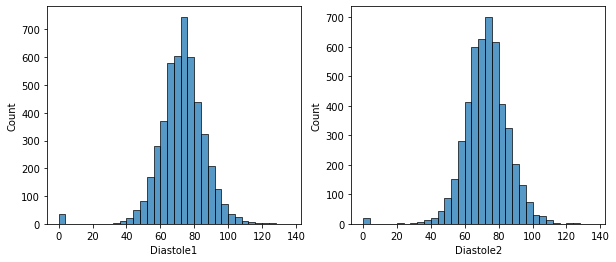

In [33]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharex=True)
sns.histplot(data=df2, x='Diastole1', binwidth=4, ax=axes[0])
sns.histplot(data=df2, x='Diastole2', binwidth=4, ax=axes[1])
plt.show()

		Pearson corr: 0.8838


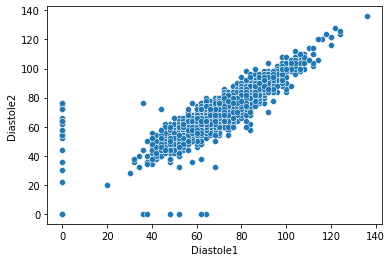

In [34]:
print('\t\tPearson corr: {:.4f}'.format(df2['Diastole1'].corr(df2['Diastole2'])))
sns.scatterplot(data=df2, x='Diastole1', y='Diastole2');

Observamos através do histograma que ambas as distribuições são simétricas a menos de um pequeno conjunto de outliers próximos à 0mmHg. O scatterplot enfim reforça a presença destes e mais outros outliers que tentaremos remover no passo seguinte utilizando a razão entre as duas variáveis para aplicar a técnica do z-score robusto.

In [35]:
threshold = 3.5

diastole_ratio = df2['Diastole1']/df2['Diastole2']
mad = abs(diastole_ratio - diastole_ratio.median()).median()/0.6745
df3 = df2[abs(diastole_ratio - diastole_ratio.median())/mad < threshold]
print('Nº de linhas removidas = {}\nNº de linhas restantes = {}'.format(df2.shape[0] - df3.shape[0], df3.shape[0]))

Nº de linhas removidas = 117
Nº de linhas restantes = 4694


		Pearson corr: 0.9428


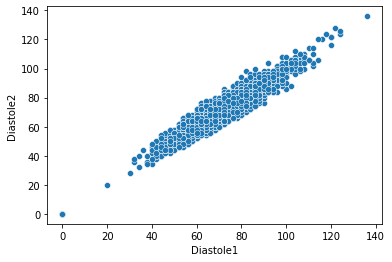

In [36]:
print('\t\tPearson corr: {:.4f}'.format(df3['Diastole1'].corr(df3['Diastole2'])))
sns.scatterplot(data=df3, x='Diastole1', y='Diastole2');

A remoção dos outliers usando uma abordagem bivariada removeu quase todas as amostras de diástole iguais a 0mmHg. Entretando, outliers próximos a reta de regressão foram mantidos mesmo estando visivelmente longe o suficiente dos pontos centrais da distribuição conjunta. A dificuldade em lidar com estes outliers persiste mesmo se o limiar do z-score robusto for menor que 3.5.

In [37]:
threshold = 2

df4 = df2[abs(diastole_ratio - diastole_ratio.median())/mad < threshold]
print('Nº de linhas removidas = {}\nNº de linhas restantes = {}'.format(df2.shape[0] - df4.shape[0], df4.shape[0]))

Nº de linhas removidas = 525
Nº de linhas restantes = 4286


		Pearson corr: 0.9621


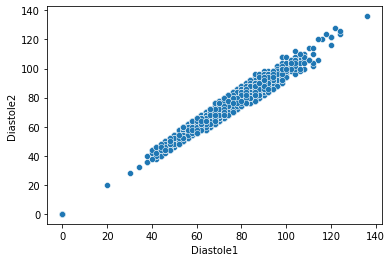

In [38]:
print('\t\tPearson corr: {:.4f}'.format(df4['Diastole1'].corr(df4['Diastole2'])))
sns.scatterplot(data=df4, x='Diastole1', y='Diastole2');

Para tentar contornar este problema, iremos utilizar o método multivariado Elliptic Envelope. 

In [39]:
from sklearn.covariance import EllipticEnvelope

df5 = df.copy()
df5 = df5.drop(columns='Age_Intervals')
df5 = df5.dropna()
print('Nº de linhas removidas pelo dropna = {}\nNº de linhas restantes = {}'.format(df.shape[0] - df5.shape[0], df5.shape[0]))

df5['Gender'] = df5['Gender'].astype('category')
df5['Education'] = df5['Education'].astype('category')
df5['Marital'] = df5['Marital'].astype('category')

df5['Gender'] = df5['Gender'].cat.codes
df5['Education'] = df5['Education'].cat.codes
df5['Marital'] = df5['Marital'].cat.codes

detector = EllipticEnvelope(contamination=0.2)
detector.fit(df5)
scores = detector.predict(df5)
lines_before = df5.shape[0]
df5 = df5[scores != -1]
print('Nº de linhas removidas pelo Elliptic Envelope = {}\nNº de linhas restantes = {}'.format(lines_before - df5.shape[0], df5.shape[0]))

Nº de linhas removidas pelo dropna = 1014
Nº de linhas restantes = 4519
Nº de linhas removidas pelo Elliptic Envelope = 904
Nº de linhas restantes = 3615


		Pearson corr: 0.9260


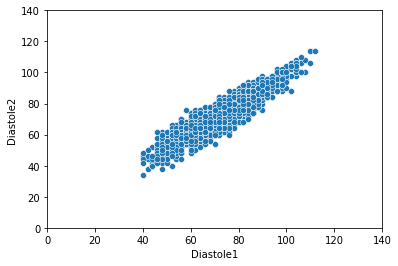

In [40]:
print('\t\tPearson corr: {:.4f}'.format(df5['Diastole1'].corr(df5['Diastole2'])))
sns.scatterplot(data=df5, x='Diastole1', y='Diastole2').set(xlim=(0,140), ylim=(0,140));

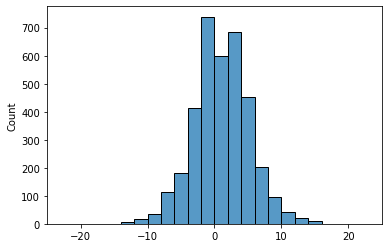

In [41]:
sns.histplot(df5['Diastole1'] - df5['Diastole2'], binwidth=2).set(xlim=(-25,25));

Vamos executar um teste de Shapiro-Wilk para verificar se a distribuição das diferenças acima possui distribuição normal.

In [42]:
stats.shapiro(df5['Diastole1'] - df5['Diastole2'])

(0.9769898653030396, 9.556062212899221e-24)

O teste de Shapiro-Wilk revelou um p-value igual a 9.55e-24 que é menor que o nível de significância de 5%. Portanto, rejeitamos a hipótese nula de que a distribuição das diferenças é aproximadamente normal e por isso devemos usar um teste de Wilcoxon para verificar se as medidas pareadas de diástole são estatisticamente iguais.

In [43]:
stats.wilcoxon(df5['Diastole1'], df5['Diastole2'])

WilcoxonResult(statistic=2243937.5, pvalue=0.4912980853628047)

O teste de Wilcoxon revelou um p-value maior que o nível de significância de 5%. Consequentemente, aceitamos a hipótese nula de que as medidas de diástole1 e diástole2 são iguais.